In [1]:
import logging
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
batch_size = 128
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [3]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

Epoch 1/6
469/469 [==============================] - 8s 7ms/step - loss: 0.3562 - sparse_categorical_accuracy: 0.9022 - val_loss: 0.1888 - val_sparse_categorical_accuracy: 0.9462
Epoch 2/6
469/469 [==============================] - 2s 5ms/step - loss: 0.1656 - sparse_categorical_accuracy: 0.9524 - val_loss: 0.1393 - val_sparse_categorical_accuracy: 0.9582
Epoch 3/6
469/469 [==============================] - 2s 5ms/step - loss: 0.1194 - sparse_categorical_accuracy: 0.9650 - val_loss: 0.1084 - val_sparse_categorical_accuracy: 0.9672
Epoch 4/6
469/469 [==============================] - 2s 5ms/step - loss: 0.0934 - sparse_categorical_accuracy: 0.9733 - val_loss: 0.1026 - val_sparse_categorical_accuracy: 0.9682
Epoch 5/6
469/469 [==============================] - 3s 6ms/step - loss: 0.0768 - sparse_categorical_accuracy: 0.9773 - val_loss: 0.0911 - val_sparse_categorical_accuracy: 0.9702
Epoch 6/6
469/469 [==============================] - 2s 5ms/step - loss: 0.0632 - sparse_categorical_accu

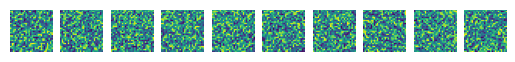

epoch: 0/100 Average MSE: 157.47650146484375


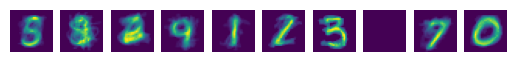

epoch: 10/100 Average MSE: 84.25640106201172


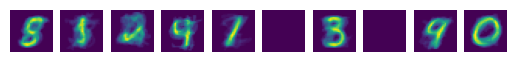

epoch: 20/100 Average MSE: 84.80548095703125


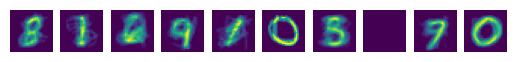

epoch: 30/100 Average MSE: 83.86583709716797


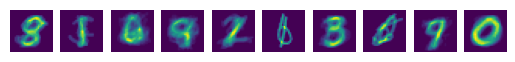

epoch: 40/100 Average MSE: 84.41088104248047


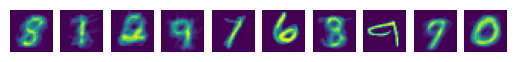

epoch: 50/100 Average MSE: 84.6810531616211


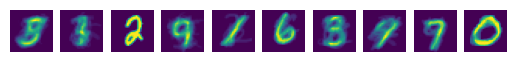

epoch: 60/100 Average MSE: 83.38014221191406


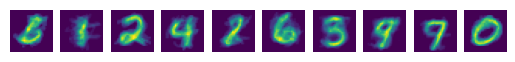

epoch: 70/100 Average MSE: 83.60652160644531


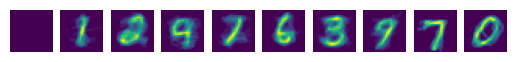

epoch: 80/100 Average MSE: 83.17789459228516


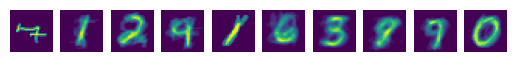

epoch: 90/100 Average MSE: 84.6372299194336


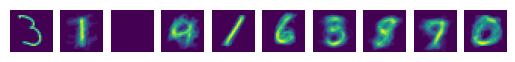

epoch: 100/100 Average MSE: 84.58518981933594


In [5]:
def random_centers(size):
    return tf.random.uniform(
    size,
    minval=0.0,
    maxval=1.0,
    dtype=tf.dtypes.float32,
)

epochs = 100
epochs_complete = 0
n_centroids = 10
centroids = random_centers((n_centroids,784))
ds_subset = ds_train.take(epochs + 1)
mses = []

for batch_x, batch_y in ds_subset:

    centroid_broadcast = tf.tile(tf.expand_dims(centroids,axis=1),multiples=[1,batch_size,1])
    batch_x = tf.reshape(batch_x, (batch_size, -1))
    dist_norm = tf.norm(batch_x, ord='euclidean')
    batch_broadcast = tf.tile(tf.expand_dims(batch_x,axis=0),multiples=[n_centroids,1,1])
    dists = tf.math.sqrt(tf.reduce_sum(tf.square(batch_broadcast - centroid_broadcast),axis=-1))
    mse = tf.reduce_sum(dists) / batch_size
    mses.append(mse)
    closest_centroids = tf.math.argmin(dists, axis=0)
    new_centroids = []

    if epochs_complete % 10 == 0: #eyeball eval
        f, axarr = plt.subplots(1,10)
        plt.subplots_adjust(bottom=0)
        for i, c_data in enumerate(centroids):
            axarr[i].imshow(tf.reshape(c_data, (28,28)))
            axarr[i].axis('off')
        plt.show()
        slice = 1 if len(mses) < 10 else 10
        print(f"epoch: {epochs_complete}/{epochs} Average MSE: {sum(mses[-slice:]) / slice}")

    for n in range(n_centroids):
        centroid_sum = tf.zeros((784))
        centroid_members = tf.where(closest_centroids == n)
        for ix in centroid_members:
            centroid_sum += batch_x[ix[0]]
        div = 1 if not len(centroid_members) else len(centroid_members)
        new_centroids.append(centroid_sum / div)
    centroids = tf.stack(new_centroids)
    epochs_complete += 1